# Tennis RL

---

This notebook demonstrates how to train the Unity Tennis ML-Agents using DDPG algorithm.
### 1. Start the Environment

We begin by installing

In [ ]:
!pip -q install ./python

and importing the necessary packages.

In [1]:
import datetime

from unityagents import UnityEnvironment
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

from ddpg_agent import MultiAgent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [ ]:
# Load Environment
env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")


# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]


### 2. Training

In [3]:
def train(agent, n_episodes=1000, max_t=100, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
#     writer = SummaryWriter()  
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()        
        
        # get the current state (for each agent)
        states = env_info.vector_observations
        score = np.zeros(agent.num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name] 
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break 
        if i_episode % 10 == 0:
            agent.learn()
        
        max_score = score.max()
        # save most recent score
        scores_window.append(max_score) 
        # save most recent score
        scores.append(max_score)
#         writer.add_scalar('scores', max_score, i_episode)
        
        if i_episode % 1000 == 0:
            # save model
            torch.save(agent.agents[0].actor_local.state_dict(), 'actro_checkpoint_training.pth')
            torch.save(agent.agents[0].critic_local.state_dict(), 'critic_checkpoint_training.pth')

        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 1000 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    
    writer.close()            
    
    return scores

In [ ]:
# Create an agent
agent = MultiAgent(state_size, action_size, num_agents)
# Run training
scores = train(agent, 70000)

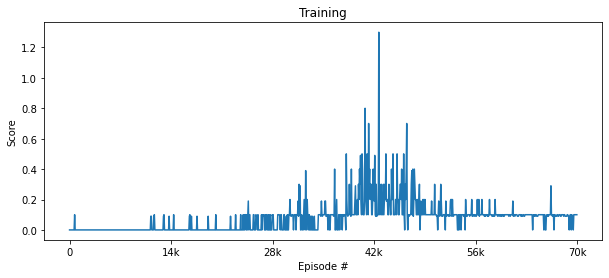

In [14]:
# plot the scores
fig = plt.figure(figsize=(10,4))
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #');
plt.title('Training')
plt.xticks([0, 200, 400, 600, 800, 1000],'0 14k 28k 42k 56k 70k'.split(' '));

In [9]:
data.shape

(1000,)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
from model import Actor

def test(model_path,  n_episodes=100, max_t=1000):
    env_info = env.reset(train_mode=True)[brain_name]
    # size of each action
    action_size = brain.vector_action_space_size
    # examine the state space 
    states = env_info.vector_observations
    state_size = states.shape[1]
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # load model
    model = Actor(state_size, action_size, seed=0).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    scores = np.zeros(n_episodes)
    scores_avg = np.zeros(n_episodes)

    scores_window = deque(maxlen=100)  # last 100 scores

    with torch.no_grad():
        for i in range(n_episodes):                                      # play game for 5 episodes
            env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
            states = env_info.vector_observations                  # get the current state (for each agent)
            states = torch.from_numpy(states).float().to(device)
            score = np.zeros(num_agents)                          # initialize the score (for each agent)
            while True:
                actions = model(states).cpu().numpy()              # select an action (for each agent)
                env_info = env.step(actions)[brain_name]           # send all actions to tne environment
                next_states = env_info.vector_observations         # get next state (for each agent)
                next_states = torch.from_numpy(next_states).float().to(device)
                rewards = env_info.rewards                         # get reward (for each agent)
                dones = env_info.local_done                        # see if episode finished
                score += env_info.rewards                         # update the score (for each agent)
                states = next_states                               # roll over states to next time step
                if np.any(dones):                                  # exit loop if episode finished
                    break
            
            scores[i] = max(score) 
            # save most recent score
            scores_window.append(max(score))
            scores_avg[i] = np.mean(scores_window)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
    return scores, scores_avg

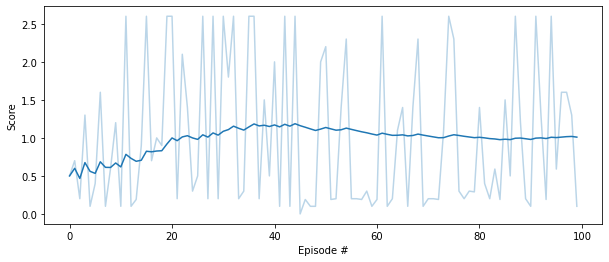

In [17]:
scores, avg = test('actor_checkpoint.pth')
fig = plt.figure(figsize=(10,4))
plt.plot(scores, color='C0', alpha=.3)
plt.plot(avg, color='C0')
plt.ylabel('Score')
plt.xlabel('Episode #');

When finished, you can close the environment.

In [19]:
env.close()